<a href="https://colab.research.google.com/github/statisticallyfit/PythonNeuralNetNLP/blob/master/SkipGram_Rajamohan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Ana-Maria Vintila, based off work from Srijith Rajamohan based off the work by Robert Guthrie

Source: https://srijithr.gitlab.io/post/word2vec/

In [6]:
import os
from IPython.display import Image

pth = os.getcwd()
pth

'/content/gdrive/My Drive/StatFitScholarshipProject/PythonNeuralNetNLP'

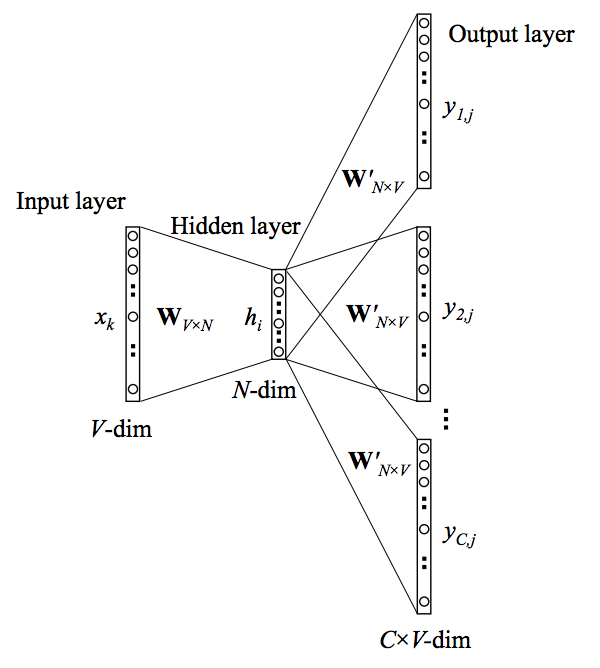

In [7]:
Image(filename=pth + '/src/NLPstudy/images/Skip-gram.png')

Loading the imports:

In [8]:
import torch
import torch.tensor as Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import urllib.request
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

torch.manual_seed(1)

# Step 1: Initialization
Here we set the context window size to $3$ words and the word embedding dimension to $10$, and also pass in the text corpora from which we build vocabulary.

Tokenizing the text occurs later while reading in the data.

In [0]:
CONTEXT_SIZE = 3
EMBEDDING_DIM = 10

testSentence = """Empathy for the poor may not come easily to people who never experienced it.
They may blame the victims and insist their predicament can be overcome through determination
and hard work.
But they may not realize that extreme poverty can be psychologically and physically
incapacitating — a perpetual cycle of bad diets, health care and education exacerbated
by the shaming and self-fulfilling prophecies that define it in the public imagination.
Gordon Parks — perhaps more than any artist — saw poverty as “the most savage of all human
afflictions” and realized the power of empathy to help us understand it. It was neither an
abstract problem nor political symbol, but something he endured growing up destitute in rural
Kansas and having spent years documenting poverty throughout the world, including the United
States.
That sensitivity informed “Freedom’s Fearful Foe: Poverty,” his celebrated photo essay published
 in Life magazine in June 1961. He took readers into the lives of a Brazilian boy, Flavio
 da Silva, and his family, who lived in the ramshackle Catacumba favela in the hills outside
 Rio de Janeiro. These stark photographs are the subject of a new book, “Gordon Parks: The
  Flavio Story” (Steidl/The Gordon Parks Foundation), which accompanies a traveling exhibition
  co-organized by the Ryerson Image Centre in Toronto, where it opens this week, and
  the J. Paul Getty Museum. Edited with texts by the exhibition’s co-curators, Paul Roth and
  Amanda Maddox, the book also includes a recent interview with Mr. da Silva and essays by
  Beatriz Jaguaribe, Maria Alice Rezende de Carvalho and Sérgio Burgi.
""".split()

# Step 2: Build the $n$-grams
Next we build the $n$-grams, or sequence of words, as a list of tuples.

Each tuple is ([ `word`$_{i-2}$, `word`$_{i-1}$ ], `targetWord`)

In [0]:
ngrams = []
for i in range(len(testSentence) - CONTEXT_SIZE):
    tup = [testSentence[j] for j in np.arange(i + 1, i + CONTEXT_SIZE + 1)]
    # skip-gram way of appending:
    ngrams.append( (testSentence[i], tup) )
    # cbow# ngrams.append( (tup, testSentence[i + CONTEXT_SIZE]) )

In [13]:
ngrams[:20] # showing a few sample n-grams

[('Empathy', ['for', 'the', 'poor']),
 ('for', ['the', 'poor', 'may']),
 ('the', ['poor', 'may', 'not']),
 ('poor', ['may', 'not', 'come']),
 ('may', ['not', 'come', 'easily']),
 ('not', ['come', 'easily', 'to']),
 ('come', ['easily', 'to', 'people']),
 ('easily', ['to', 'people', 'who']),
 ('to', ['people', 'who', 'never']),
 ('people', ['who', 'never', 'experienced']),
 ('who', ['never', 'experienced', 'it.']),
 ('never', ['experienced', 'it.', 'They']),
 ('experienced', ['it.', 'They', 'may']),
 ('it.', ['They', 'may', 'blame']),
 ('They', ['may', 'blame', 'the']),
 ('may', ['blame', 'the', 'victims']),
 ('blame', ['the', 'victims', 'and']),
 ('the', ['victims', 'and', 'insist']),
 ('victims', ['and', 'insist', 'their']),
 ('and', ['insist', 'their', 'predicament'])]

# Step 3: Create Vocabulary
Create the vocabulary by converting the text into a `set` to remove duplicate words.

In [0]:
vocabulary = set(testSentence)

In [23]:
len(vocabulary)
list(vocabulary)[:20] # showing first 20 words in vocabulary

['lived',
 'psychologically',
 'prophecies',
 'Gordon',
 'Silva',
 'They',
 'abstract',
 'perpetual',
 'hills',
 'Silva,',
 'power',
 'magazine',
 'imagination.',
 'something',
 'recent',
 'all',
 'may',
 'understand',
 'cycle',
 'who']

# Step 4: Create Map of Words to Indices

Creating word to index map that prints the key (word) corresponding to the given index in the dictionary argument. Basically, we get a list of tuples (number, word) from zipping the sequence $0,1,2,3 ....$ with the vocabulary word list.

In [0]:
wordToIndex = {word : i for i, word in enumerate(vocabulary)}

In [31]:
# Showing first 20 word to index pairs
len(wordToIndex)
itemsList = list(wordToIndex.items())
itemsList[:20]

[('lived', 0),
 ('psychologically', 1),
 ('prophecies', 2),
 ('Gordon', 3),
 ('Silva', 4),
 ('They', 5),
 ('abstract', 6),
 ('perpetual', 7),
 ('hills', 8),
 ('Silva,', 9),
 ('power', 10),
 ('magazine', 11),
 ('imagination.', 12),
 ('something', 13),
 ('recent', 14),
 ('all', 15),
 ('may', 16),
 ('understand', 17),
 ('cycle', 18),
 ('who', 19)]

In [0]:
def printKey(iWord, wordToIndexDict):
    """
    Prints the key (the word) corresponding to the given index in the given dictionary.

    :param iWord: index of a word in the given dict
    :param wordToIndexDict: the dictionary
    :return: key
    """
    for key, index in wordToIndexDict.items():
        if(index == iWord):
            print(key)



def clusterEmbeddings(filename, numClusters):
    X = np.load(filename)
    kmeans = KMeans(n_clusters=numClusters, random_state=  0).fit(X) # from sklearn
    center = kmeans.cluster_centers_
    distances = euclidean_distances(X, center)

    for i in np.arange(0, distances.shape[1]):

        # get the index of the minimum distance in the ith row of the dist matrix
        iMinWord = np.argmin(distances[:, i])
        print(iMinWord)
        printKey(iWord=iMinWord, wordToIndexDict= wordToIndex)


def readData(filePath):
    tokenizer = RegexpTokenizer(r'\w+')
    data = urllib.request.urlopen(filePath)
    data = data.read().decode('utf8')
    tokenizedData = word_tokenize(data)

    # note: stopwords are from nltk
    stopWordsSet = set(stopwords.words('english'))
    stopWordsSet.update(['.',',',':',';','(',')','#','--','...','"'])
    cleanedWords = [word for word in tokenizedData if word not in stopWordsSet]

    return cleanedWords

# Step 6: Create Skip-Gram Model
The skip-gram neural network has three components:

1. embedding layer, created using pytorch's `nn.Embedding`, to convert tensors into word embeddings.
2. hidden layer, in this case it is a linear layer.
3. output layer, in this case also linear layer.

### Forward Pass of Skip-Gram:
1. Convert the tensor `inputs` to word embeddings via the skip-gram's `nn.Embedding` layer
2. Pass the embeddings to the hidden layer and transform the result using the `relu` function
3. Transform the hidden layer results using the output layer.
4. Finally, create a probability distribution over words using the `softmax` function. (Here we actually use the `log_softmax` so the results are log probabilities instead of probabilities. )

### Predictions:
To generate predictions we need to execute the `forward` pass of the skip-gram model and get the index of the maximum probability from the output layer. Then that index is used to find the corresponding prediction word.


In [0]:
class SkipGramModeler(nn.Module):

    def __init__(self, vocabSize: int, embeddingDim: int, contextSize: int):
        super(SkipGramModeler, self).__init__()

        # see docs: https://hyp.is/cv2pSAeqEeqIRHv7JAjgtA/pytorch.org/docs/stable/nn.html
        # num_embeddings = size of the dictionary embeddings
        # embedding_dim = the size of each embedding vector
        # Creating an embedding model that contains (vocabSize) tensors each of size (embeddingDim)
        self.embeddings = nn.Embedding(num_embeddings=vocabSize,
                                       embedding_dim=embeddingDim,
                                       padding_idx=contextSize)

        # see nn.Linear docs
        # https://hyp.is/XEDPhgerEeqFhHssJYoa-w/pytorch.org/docs/stable/nn.html
        # note: in_features = size of each input sample
        # note: out_features = size of each output sample
        self.hiddenLayer = nn.Linear(in_features=embeddingDim,
                                     out_features=128)

        self.outputLayer = nn.Linear(in_features=128,
                                     out_features=contextSize * vocabSize)


    def forward(self, inputs: Tensor) -> Tensor:
        """

        :param inputs: 1-dim tensor
        :return:
        """
        # note: -1 implies the size inferred for that index from the size of data
        # is a tensor
        inputEmbeddings: Tensor = self.embeddings(inputs).view((1,-1))

        # output at hidden layer
        hiddenRELUResults: Tensor = F.relu(self.hiddenLayer(inputEmbeddings))
        # output at final layer
        outputResults: Tensor = self.outputLayer(hiddenRELUResults)

        logProbs: Tensor = F.log_softmax(input=outputResults, dim=1).view(CONTEXT_SIZE, -1)

        return logProbs



    def predict(self, inputStr: str, wordToIndexDict: dict) -> list:
        """

        :param inputStr: single word (targetword) from which we predict context list
        :return:
        """
        contextIndices: Tensor = torch.tensor([wordToIndexDict[inputStr]],
                                              dtype=torch.long)

        logProbs: Tensor = self.forward(contextIndices)

        # get index of maximum log probability from output layer
        #iMaxLogProbs: Tensor = torch.argmax(logProbs)

        # returns log probs sorted in descending order and
        # iSorted = indices of elements in the input tensor
        logProbsDecr, iSorted = logProbs.sort(descending=True)

        # same as logs.squeeze()[:3] (erasing first dimension)
        # since the tensor is [[...]]

        # getting sorted indices, the first one in each row of iSorted
        # (there are three rows in the iSorted, 2-dim tensor)
        numRows, numCols = iSorted.size()
        iFirstCol = 0
        indices = [iSorted[r][iFirstCol] for r in np.arange(0, numRows)]


        keyIndFilteredPairs: list = []

        for i in indices:

            keyIndFilteredPairs.append( [ (key, index)
                                       for key, index in wordToIndexDict.items()
                                       if index == i ]  )

        return keyIndFilteredPairs

    def printLayerParamers(self):
        for name, child in self.named_children():
            print("\nname = {}, child = {}".format(name, child))

            # TODO: type of child?
            for names, params in child.named_parameters():
                print("names = {}, params = {}".format(names, params))
                print("params.size() = {}".format(params.size()))


    def writeEmbeddingToFile(self, filename: str):
        for i in self.embeddings.parameters():
            weights = i.data.numpy()
        np.save(filename, weights)

In [14]:
# Trial : testing out the predict() inner workings

inputStr = "psychologically"

contextIndices: Tensor = torch.tensor([wordToIndex[inputStr]],
                                      dtype=torch.long)
print("contextIndices: ", contextIndices)
print("contextIndices dim: ", contextIndices.dim())
print("contextIndices size: ", contextIndices.size())



contextIndices:  tensor([137])
contextIndices dim:  1
contextIndices size:  torch.Size([1])


In [15]:
dummyModel = SkipGramModeler(vocabSize=len(vocabulary), embeddingDim=EMBEDDING_DIM,
                         contextSize=CONTEXT_SIZE)

logProbs: Tensor = dummyModel(contextIndices)


# returns log probs sorted in descending order and
# iSorted = indices of elements in the input tensor
logProbsDecr, iSorted = logProbs.sort(descending=True)
print("logProbsDecr dim : ", logProbsDecr.dim())
print("logProbsDecr shape : ", logProbsDecr.shape)
print("logProbsDecr squeezed: ", logProbsDecr.squeeze()[:, :5])
print("logProbsDecr squeezed dim :  ", logProbsDecr.squeeze().dim())
print("logProbsDecr squeezed shape: ", logProbsDecr.squeeze().shape)

print("\niSorted dim: ", iSorted.dim())
# note: in this case, squeezing is same as the original tensor; has no effect
print("iSorted: ", iSorted[:, :5])

logProbsDecr = logProbsDecr.squeeze()   # logProbsDecr[0][:3]
iSorted = iSorted.squeeze()



# getting sorted indices, the first one in each row of iSorted
# (there are three rows in the iSorted, 2-dim tensor)
numRows, numCols = iSorted.size()
iFirstCol = 0
indices = [iSorted[r][iFirstCol] for r in np.arange(0, numRows)]

print("\nindices = ", indices)


# it length will be numRows of iSorted (numRows = 3)
# which equals CONTEXT_SIZE
keyIndFilteredPairs: list = []

for i in indices:

    keyIndFilteredPairs.append( [ (key, index)
                                  for key, index in wordToIndex.items()
                                  if index == i ]  )

print("\nlength of key,ind pairs: ", len(keyIndFilteredPairs))
print("keyIndFilteredPairs: ", keyIndFilteredPairs)

logProbsDecr dim :  2
logProbsDecr shape :  torch.Size([3, 195])
logProbsDecr squeezed:  tensor([[-5.7581, -5.7919, -5.8080, -5.8146, -5.8202],
        [-5.5920, -5.6021, -5.6844, -5.7157, -5.7189],
        [-5.6294, -5.6362, -5.6638, -5.6691, -5.7091]],
       grad_fn=<SliceBackward>)
logProbsDecr squeezed dim :   2
logProbsDecr squeezed shape:  torch.Size([3, 195])

iSorted dim:  2
iSorted:  tensor([[107,  95,  74,  63,  11],
        [142, 106, 100,  10,  93],
        [167,   1,  44,   9,   8]])

indices =  [tensor(107), tensor(142), tensor(167)]

length of key,ind pairs:  3
keyIndFilteredPairs:  [[('traveling', 107)], [('outside', 142)], [('Foundation),', 167)]]


# Step 7: Train the Skip-Gram Model
Training the model requires the following steps:

1. Convert the context words into integer indices using the `wordToIndex` dictionary, and make their type a `Tensor`.
2. Set the model gradients to zero so they do not accumulate artificially (feature of pytorch)
3. Do the `forward` pass of the Skip-Gram model, resulting in the log probabilities of the context words.
4. For each word in the correct target context wrods, convert it to an index using the `wordToIndex` dictionary and wrap it in a `Tensor` type.
5. Compute the loss between the log probabilities and target contexts.
6. Do the `backward` pass over the neural network to update the gradients by calling `loss.backward()`.
7. Do one step using the optimizer, so that weights are updated using stochastic gradient descent.
8. Increment the total loss by this epoch's current loss.

In [16]:
%time

learningRate = 0.001
NUM_EPOCHS = 550

losses = []
lossFunction = nn.NLLLoss()
skipGramModel = SkipGramModeler(vocabSize = len(vocabulary),
                        embeddingDim=EMBEDDING_DIM,
                        contextSize=CONTEXT_SIZE)
# Using the stochastic-gradient descent optimizer.
optimizer = optim.SGD(skipGramModel.parameters(), lr = learningRate)

# Preserve the data by freezing the embedding layer
#skipGramModel.freezeLayer("embeddingsSkipGram")

for epoch in range(NUM_EPOCHS):
    totalLoss = 0

    # note: skipgram predicts CONTEXT from single word
    # while CBOW predicts single TARGET word from CONTEXT list
    for contextWord, targetContext in ngrams:

        # Step 1: Prepare the inputs to be passed to the model (means
        # turn the words into integer indices and wrap them in tensors)
        contextIndices: Tensor = torch.tensor([wordToIndex[contextWord]],
                                              dtype=torch.long)

        # Step 2:
        skipGramModel.zero_grad()

        # Step 3: run forward pass, getting log probs over the next words
        logProbs = skipGramModel(contextIndices)

        # Step 4: compute loss, where target word is wrapped in a tensor
        targetContextTensor: Tensor = torch.tensor([wordToIndex[w] for w in targetContext],
                                           dtype=torch.long)

        loss = lossFunction(logProbs, targetContextTensor)

        # Step 5: do backward pass and update gradient
        loss.backward()
        optimizer.step()

        totalLoss += loss.item()

    if(epoch % 50 == 0):
        print("Epoch = {}, Total loss = {}".format(epoch, totalLoss))

    losses.append(totalLoss)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs
Epoch = 0, Total loss = 1640.9999227523804
Epoch = 50, Total loss = 1518.4927296638489
Epoch = 100, Total loss = 1414.1443753242493
Epoch = 150, Total loss = 1292.492782831192
Epoch = 200, Total loss = 1149.2484674453735
Epoch = 250, Total loss = 998.4024060964584
Epoch = 300, Total loss = 857.8129457235336
Epoch = 350, Total loss = 742.0071568489075
Epoch = 400, Total loss = 655.678228020668
Epoch = 450, Total loss = 594.8056415319443
Epoch = 500, Total loss = 552.3266983032227


In [0]:
skipGramModel.predict(inputStr = "psychologically", wordToIndexDict=wordToIndex)
skipGramModel.writeEmbeddingToFile(filename = pth + "/src/NLPstudy/SkipGramModel/rajamohan_skipgram_embeddings.txt")

In [19]:
clusterEmbeddings(filename = pth + "/src/NLPstudy/SkipGramModel/rajamohan_skipgram_embeddings.txt.npy", numClusters=5)

3
shaming
28
victims
191
It
18
book,
87
Silva,
